# Programming Assignment 4: Sentiment analysis with SVM

In this programming assignment, we will revisit the problem of sensiment analysis, but using a different approach. Recall that the task is to predict the *sentiment* (positive or negative) of a single sentence taken from a review of a movie, restaurant, or product. The data set consists of 3000 labeled sentences, which we divide into a training set of size 2500 and a test set of size 500. Previously we found a logistic regression classifier. Today we will use a support vector machine.

Make sure the notebook is in the same folder that contains `full_set.txt`.

## 1. Load and preprocess data

In [224]:
%matplotlib inline
import string
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)

The data set consists of 3000 sentences, each labeled '1' (if it came from a positive review) or '0' (if it came from a negative review). To be consistent with our notation from lecture, we will change the negative review label to '-1'.

In [225]:
## Read in the data set.
with open("full_set.txt") as f:
    content = f.readlines()
    
## Remove leading and trailing white space
content = [x.strip() for x in content]

## Separate the sentences from the labels
sentences = [x.split("\t")[0] for x in content]
labels = [x.split("\t")[1] for x in content]

## Transform the labels from '0 v.s. 1' to '-1 v.s. 1'
y = np.array(labels, dtype='int8')
y = 2*y - 1

### Preprocessing the text data

To transform this prediction problem into one amenable to linear classification, we will first need to preprocess the text data. We will do four transformations:

1. Remove punctuation and numbers.
2. Transform all words to lower-case.
3. Remove _stop words_.
4. Convert the sentences into vectors, using a bag-of-words representation.

We begin with first two steps.

In [226]:
## full_remove takes a string x and a list of characters removal_list 
## returns x with all the characters in removal_list replaced by ' '
def full_remove(x, removal_list):
    for w in removal_list:
        x = x.replace(w, ' ')
    return x

## Remove digits
digits = [str(x) for x in range(10)]
digit_less = [full_remove(x, digits) for x in sentences]

## Remove punctuation
punc_less = [full_remove(x, list(string.punctuation)) for x in digit_less]

## Make everything lower-case
sents_lower = [x.lower() for x in punc_less]

### Stop words

Stop words are words that are filtered out because they are believed to contain no useful information for the task at hand. These usually include articles such as 'a' and 'the', pronouns such as 'i' and 'they', and prepositions such 'to' and 'from'. We have put together a very small list of stop words, but these are by no means comprehensive. Feel free to use something different; for instance, larger lists can easily be found on the web.

In [227]:
## Define our stop words
stop_set = set(['the', 'a', 'an', 'i', 'he', 'she', 'they', 'to', 'of', 'it', 'from'])

## Remove stop words
sents_split = [x.split() for x in sents_lower]
sents_processed = [" ".join(list(filter(lambda a: a not in stop_set, x))) for x in sents_split]

### Bag of words

In order to use linear classifiers on our data set, we need to transform our textual data into numeric data. The classical way to do this is known as the _bag of words_ representation. In this representation, each word is thought of as corresponding to a number in `{1, 2, ..., d}` where `d` is the size of our vocabulary. And each sentence is represented as a d-dimensional vector $x$, where $x_i$ is the number of times that word $i$ occurs in the sentence.

To do this transformation, we will make use of the `CountVectorizer` class in `scikit-learn` (Note that this is the only time you can call an external function from scikit-learn). We will cap the number of features at 4500, meaning a word will make it into our vocabulary only if it is one of the 4500 most common words in the corpus. This is often a useful step as it can weed out spelling mistakes and words which occur too infrequently to be useful.

Once we get the bag-of-words representation, append a '1' to the beginning of each vector to allow our linear classifier to learn a bias term.

In [228]:
from sklearn.feature_extraction.text import CountVectorizer

## Transform to bag of words representation.
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 4500)
data_features = vectorizer.fit_transform(sents_processed)
data_mat = data_features.toarray()
print ('The original size: ',data_features.shape)

The original size:  (3000, 4500)


### Training / test split

Finally, we split the data into a training set of 2500 sentences and a test set of 500 sentences (of which 250 are positive and 250 negative).

In [229]:
## Split the data into testing and training sets
np.random.seed(0)
test_inds = np.append(np.random.choice((np.where(y==-1))[0], 250, replace=False), np.random.choice((np.where(y==1))[0], 250, replace=False))
train_inds = list(set(range(len(labels))) - set(test_inds))

train_data = data_mat[train_inds,]
train_labels = y[train_inds]

test_data = data_mat[test_inds,]
test_labels = y[test_inds]

print("train data: ", train_data.shape)
print("test data: ", test_data.shape)

train data:  (2500, 4500)
test data:  (500, 4500)


## 2. Solving for soft-margin SVM


Recall that support vector machine (SVM) finds a linear decision boundary with the largest margin for a binary classification problem. Suppose we have a training dataset $\{(x_{1},y_1),...,(x_n,y_n)\}$
where $x_{i} \in \mathbb{R}^{d}$ are feature vectors and $y_i\in\{-1,+1\}$ are labels.  The linear classifier is parametrized by $\theta\in \mathbb{R}^{d}$ and $\theta_0\in\mathbb{R}$, and predicts +1 at a point $x$ if $\theta\cdot x+\theta_0>0$ and -1 otherwise. 

It turns out that the soft-margin SVM optimization is equivalent to the following unconstrained optimization:
$$\underset{\theta\in\mathbb{R}^d,\theta\in\mathbb{R}}{\text{min}}\|\theta\|^2+C\sum_{i=1}^n\ell_{\mathrm{hinge}}(y_i(\theta\cdot x_i+\theta_0))$$
where  $\ell_{\mathrm{hinge}}(t)=\max(0,1-t)$ is called the ``hinge loss,'' which takes value $1-t$ if $t<1$ and 0 otherwise. For example, $\ell_{\mathrm{hinge}}(-1)=2$, and $\ell_{\mathrm{hinge}}(2)=0$. 


It turns out that for gradient-based optimization, hinge loss may be difficult to deal with because it is not differentiable at point $t=1$. One solution is to use the ``smoothed version'' of hinge loss:

$$\ell_{\mathrm{smooth-hinge}}(t) = \begin{cases}
\frac{1}{2} - t      & \text{if} ~~ t \le 0, \\
\frac{1}{2} (1 - t)^2 & \text{if} ~~ 0 < t < 1, \\
0                      & \text{if} ~~ 1 \le t
\end{cases}$$


Thus, in the rest of the problem, we will consider the following optimization:
$$\underset{\theta\in\mathbb{R}^d,\theta\in\mathbb{R}}{\text{min}}\|\theta\|^2+C\sum_{i=1}^n\ell_{\mathrm{smooth-hinge}}(y_i(\theta\cdot x_i+\theta_0))$$

**Task P2:** Implement the hinge loss function and the smooth hinge loss function. Plot the function $\ell_{\mathrm{hinge}}(t)$ and $\ell_{\mathrm{smooth-hinge}}(t)$for $t\in[-5,5]$.

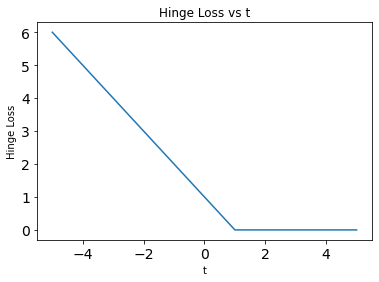

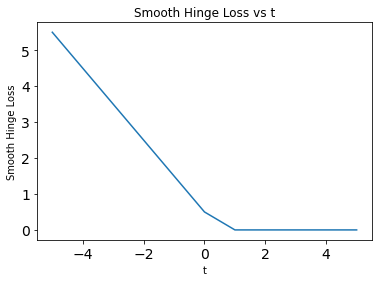

In [265]:
### STUDENT: Start of code ###
def compute_hinge_loss(t):
# calculate hinge loss
    
    hinge_loss = 0
    
    if t > 1:
        hinge_loss = ( 0 )

    else:
        hinge_loss = ( 1 - t )
    
    return hinge_loss

def hinge_loss_smooth(t):
#calculate smooth hinge loss
    smooth_hinge_loss = 0
    
    if t <= 0:
        smooth_hinge_loss = (0.5 - t)
    elif 0 < t < 1:
        smooth_hinge_loss =  0.5 * ( (1 - t**2 ) )
    elif t >= 1:
        smooth_hinge_loss = 0
            
    return smooth_hinge_loss        
    
t_array = list(range(-5,6))
hinge_loss = []
smooth_hinge_loss = []                            

for i in range(len(t_array)):
                                 
    hinge_loss.append(compute_hinge_loss(t_array[i]))
    smooth_hinge_loss.append(hinge_loss_smooth(t_array[i]))

plt.figure(1)
plt.plot(t_array, hinge_loss)
plt.xlabel("t")
plt.ylabel("Hinge Loss")
plt.title("Hinge Loss vs t")

plt.figure(2)
plt.plot(t_array, smooth_hinge_loss)
plt.xlabel("t")
plt.ylabel("Smooth Hinge Loss")
plt.title("Smooth Hinge Loss vs t")

plt.show()

### End of code ###

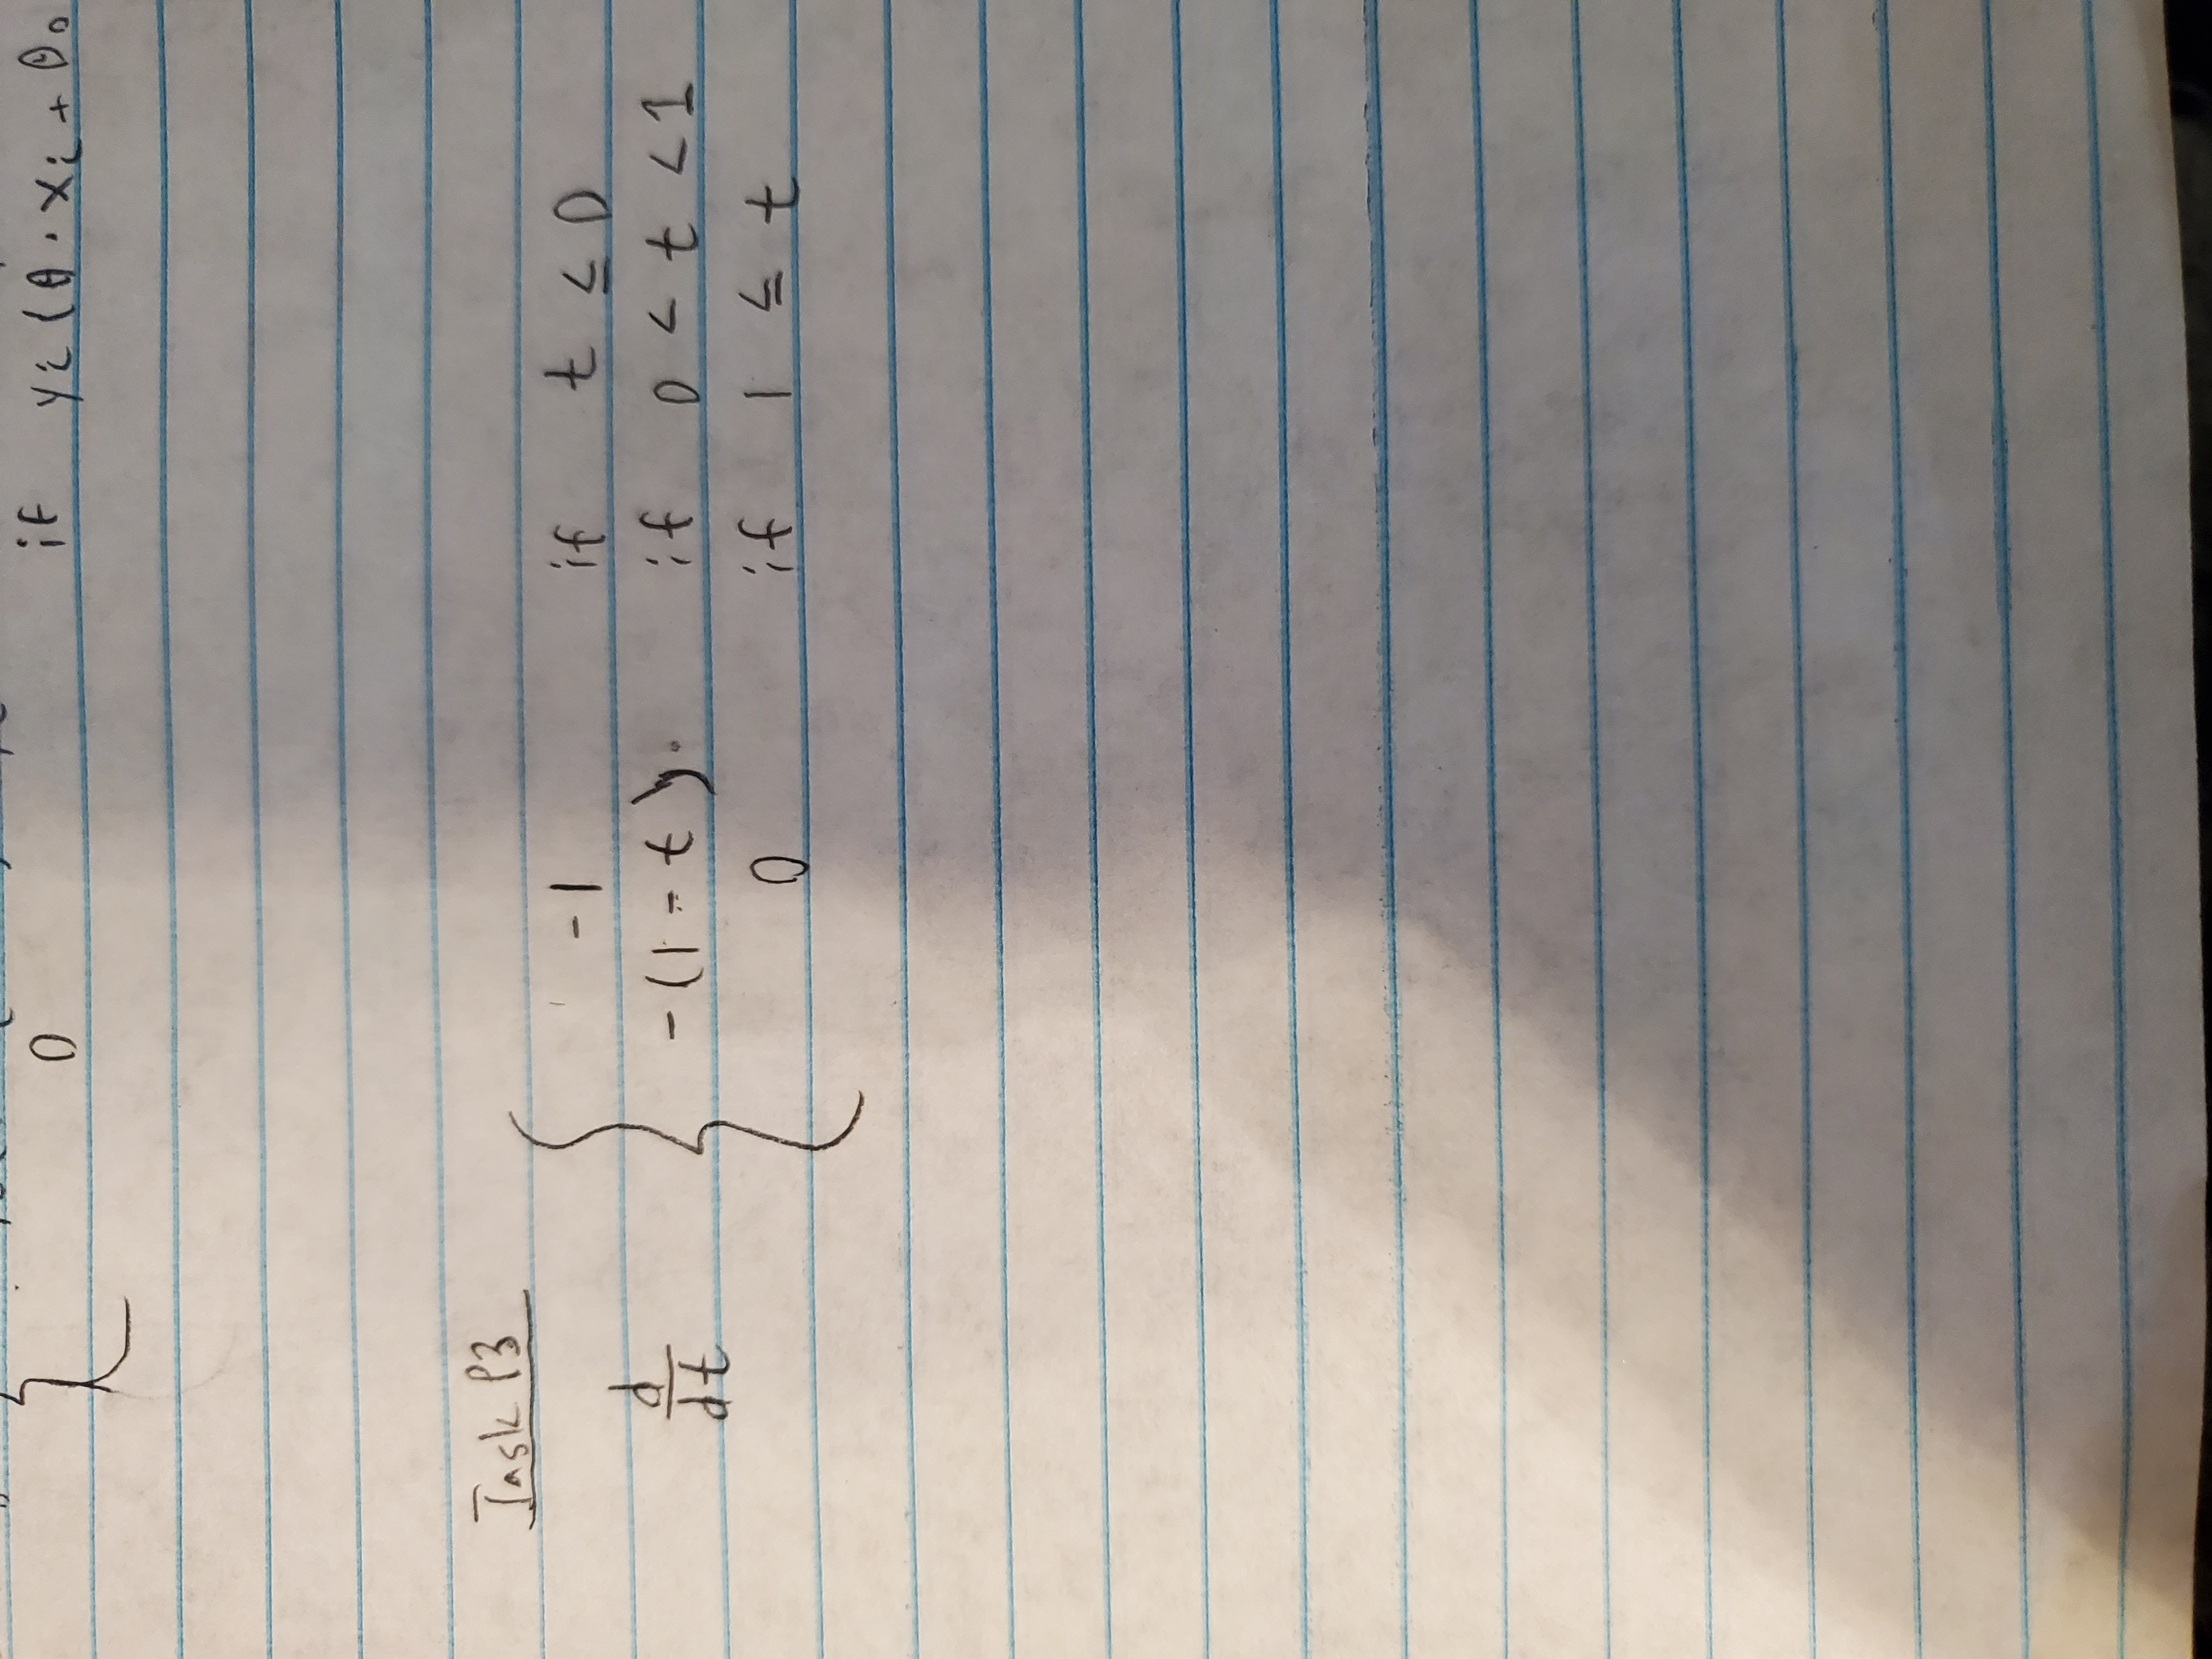

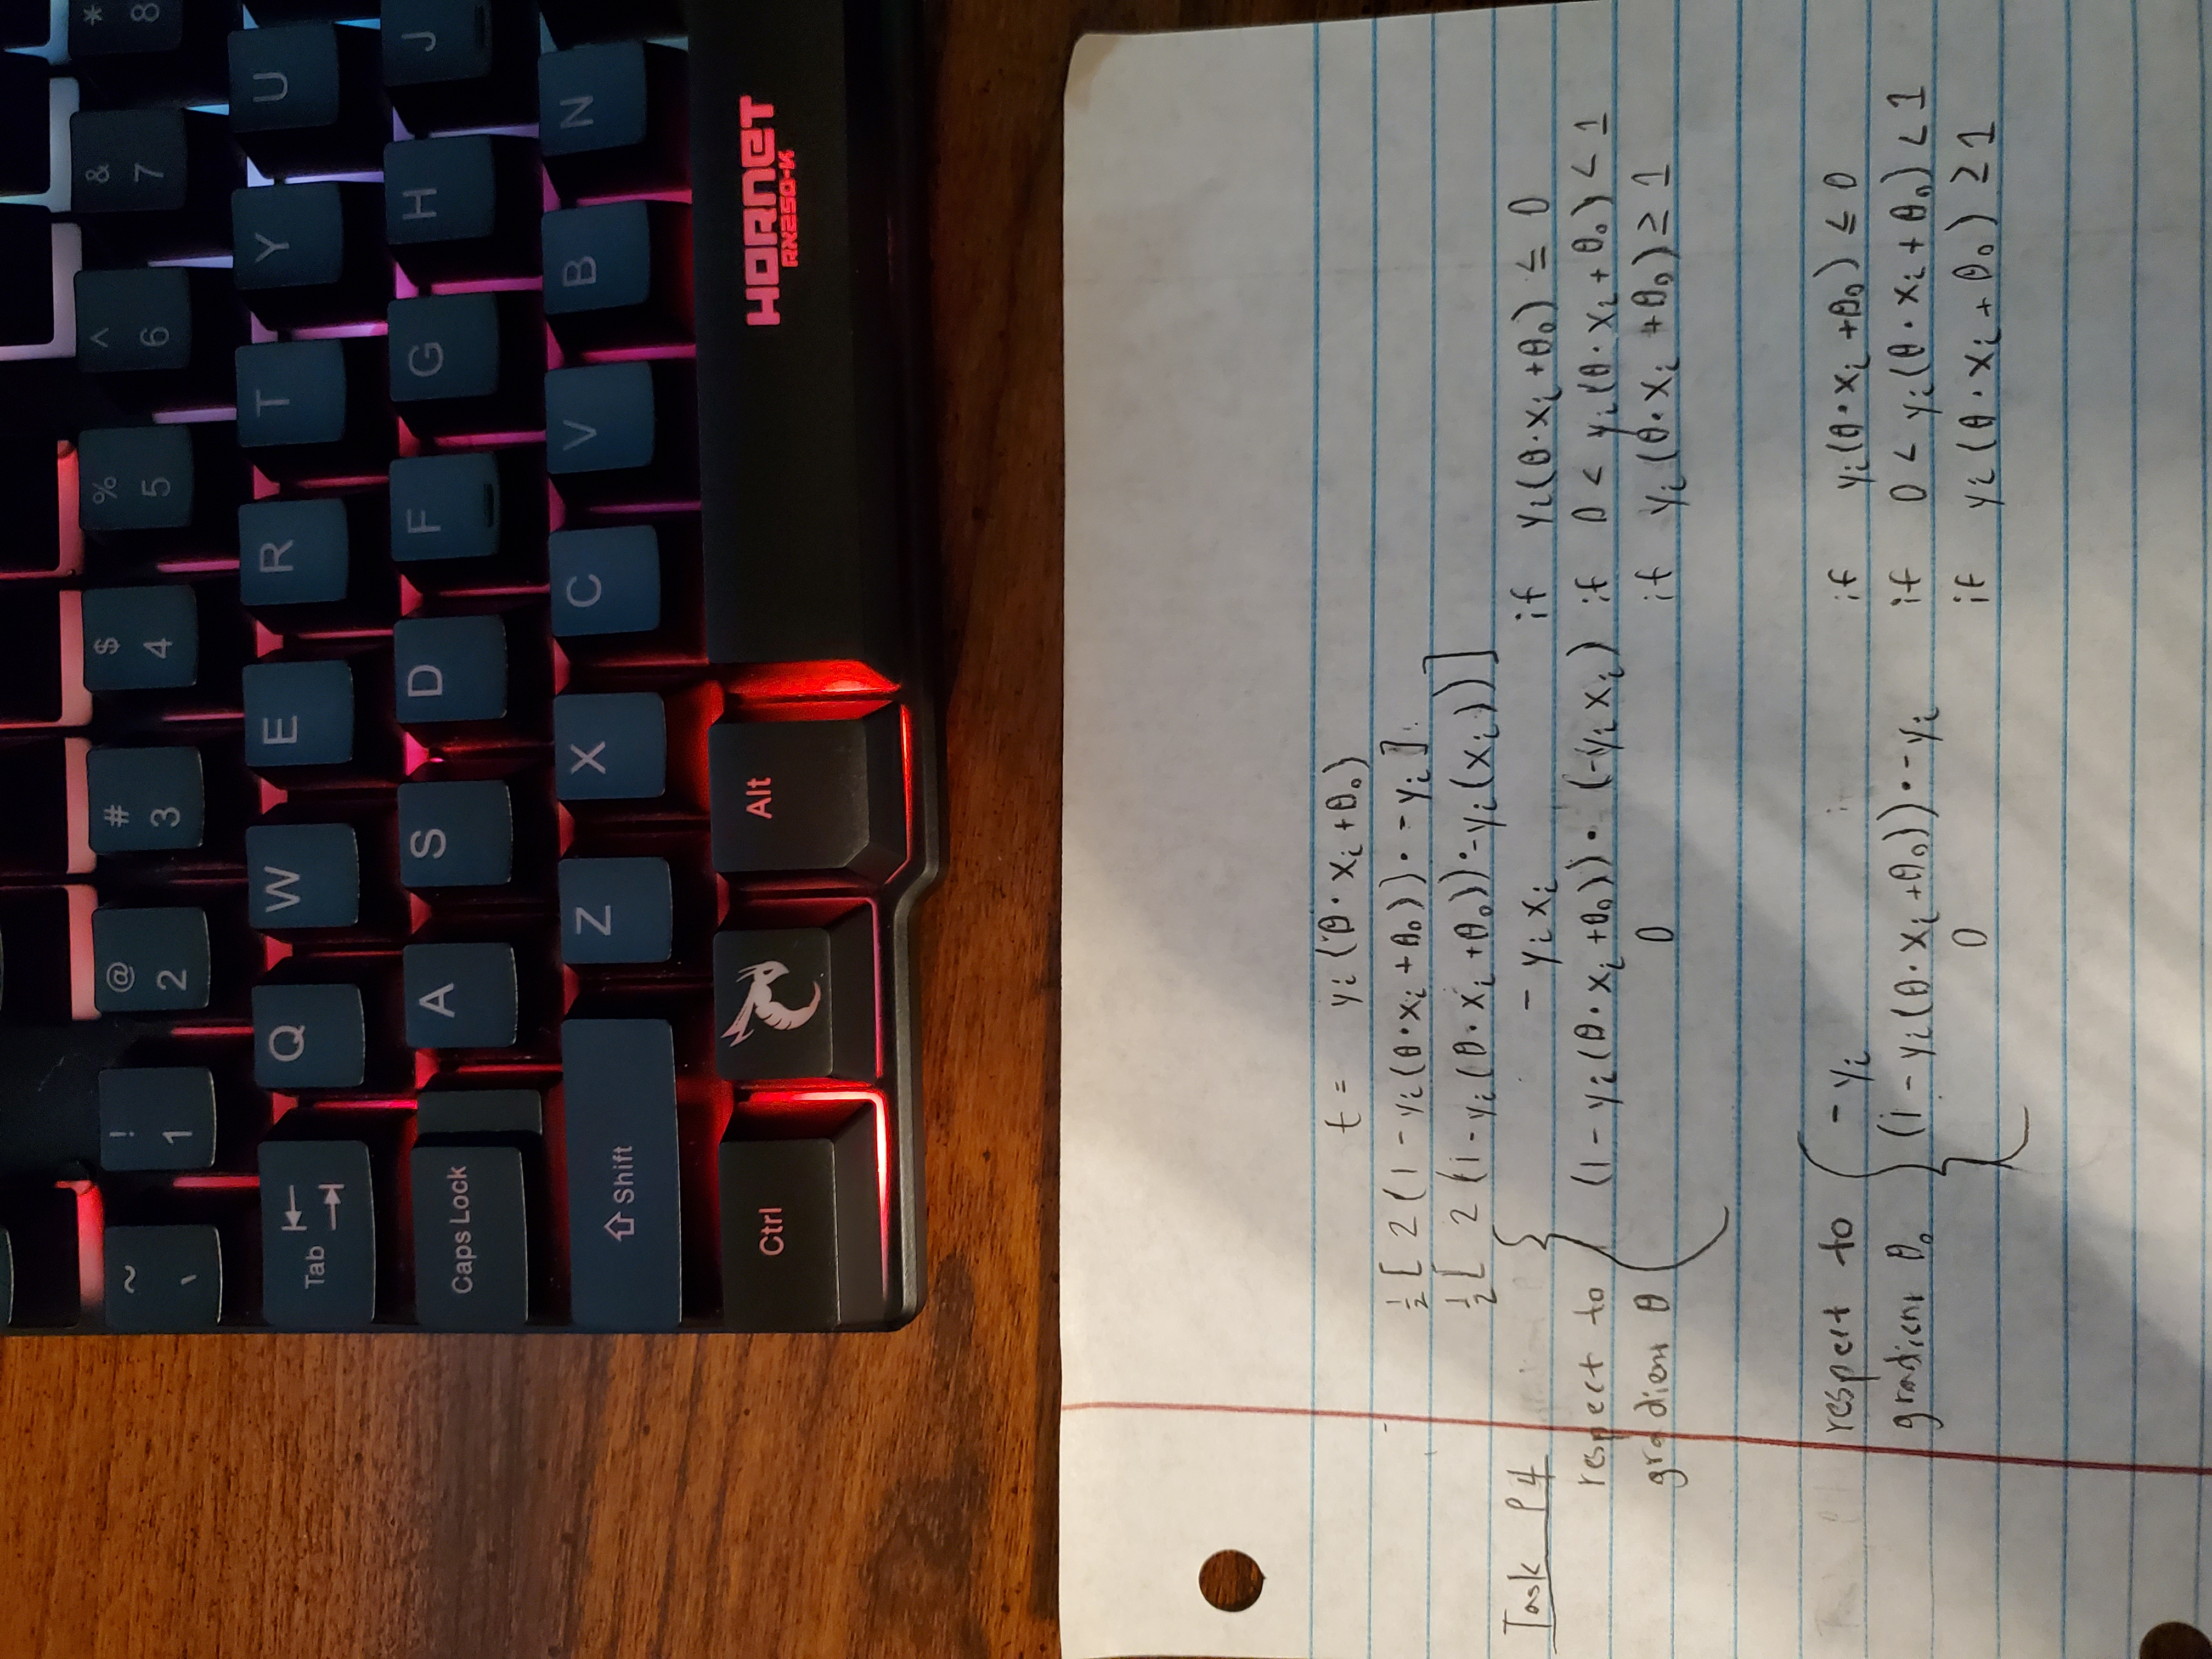

**Task P5:** Let $f(\theta,\theta_0)= \|\theta\|^2+C\sum_{i=1}^n\ell_{\mathrm{smooth-hinge}}(y_i(\theta\cdot x_i+\theta_0))$ be the objective function of the optimization problem we want to solve. Implement the function that obtains the partial derivative $\frac{\partial }{\partial \theta}f(\theta,\theta_0)$ and $\frac{\partial }{\partial \theta_0}f(\theta,\theta_0)$. Also, print out the output of the code that calculates the derivatives at $\theta=1$ and $\theta_0=1$ with $C=1$.

Hint: you need to calculate the partial derivative of the smoothed hinge loss for each data point separately, and add them together to obtain the result.

In [266]:
def weight_derivative(theta, theta0, C,feature_matrix, labels):
    # Input:
    # theta: weight vector theta, a numpy vector of dimension d
    # theta0: intercept theta0, a numpy vector of dimension 1
    # C: constant C
    # feature_matrix: numpy array of size n by d, where n is the number of data points, and d is the feature dimension
    # labels: true labels y, a numpy vector of dimension d, each with value -1 or +1
    # Output:
    # Derivative of the cost function with respect to the weight theta, grad_theta
    # Derivative of the cost function with respect to the weight theta0, grad_theta0
        
    ## STUDENT: Start of code ###
    
    check_distances = np.multiply(labels, np.dot(feature_matrix, theta) + theta0)
    #print(check_distances[0:20])
    
    theta_smooth_hinge_loss = np.array([])
    theta0_smooth_hinge_loss = np.array([])
    
    
    for i in range(0, len(check_distances) ):
        if check_distances[i] <= 0:
            calculate_theta = -labels[i] * feature_matrix[i]
            calculate_theta0 = -labels[i]
            
            theta_smooth_hinge_loss = np.append(theta_smooth_hinge_loss, calculate_theta )
            theta0_smooth_hinge_loss = np.append(theta0_smooth_hinge_loss, calculate_theta0 )
            
        if 0 < check_distances[i] < 1:
            calculate_theta = 1 - ( labels[i] * np.dot(feature_matrix[i], theta) ) * (-labels[i] * feature_matrix[i]) 
            calculate_theta0 = 1 - ( labels[i] * np.dot(feature_matrix[i], theta) ) * (-labels[i])
            
            theta_smooth_hinge_loss = np.append(theta_smooth_hinge_loss, calculate_theta)
            theta0_smooth_hinge_loss = np.append(theta0_smooth_hinge_loss, calculate_theta0)
            
        if check_distances[i] >= 1:
            theta_smooth_hinge_loss = np.append(theta_smooth_hinge_loss, 0)
            theta0_smooth_hinge_loss = np.append(theta0_smooth_hinge_loss, 0)
    

    grad_theta = 2*theta + C * np.sum(theta_smooth_hinge_loss, axis = 0)
    grad_theta0 = C * np.sum(theta0_smooth_hinge_loss, axis = 0)
        
    return grad_theta, grad_theta0
    # End of code ###

In [264]:
# STUDENT: PRINT THE OUTPUT AND COPY IT TO THE SOLUTION FILE
theta = np.ones(data_mat.shape[1]) # a weight of all 1s
theta0 = np.ones(1) # a number 1
C = 1
grad_theta, grad_theta0 = weight_derivative(theta, theta0, C,train_data,train_labels)

print (grad_theta[:10])
print (grad_theta0)


[11853. 11853. 11853. 11853. 11853. 11853. 11853. 11853. 11853. 11853.]
1250.0


**Task P6:**  For sentiment analysis data, choose a value for the trade-off parameter $C$. Report the training error at convergence and the testing error. 

Note:  you can just use the same gradient descent algorithm that we wrote in assignment 2, or use the adam_optimizer provided below.

Here is an [article](https://towardsdatascience.com/adam-latest-trends-in-deep-learning-optimization-6be9a291375c#:~:text=Adam%20%5B1%5D%20is%20an%20adaptive,for%20training%20deep%20neural%20networks.&text=The%20algorithms%20leverages%20the,learning%20rates%20for%20each%20parameter) on the Adam optimizer.

In [267]:
def objective(feature_matrix, labels, theta,theta0, C):
    score = (feature_matrix.dot(theta)+theta0)*labels
    return np.sum(theta**2)+C*np.sum([hinge_loss_smooth(t) for t in score])

In [268]:
def adam_optimizer(feature_matrix, labels, initial_theta,initial_theta0, C, step_size=0.01, tolerence=0.01, b1=0.9, b2=0.999, eps=10**-8):
    # Gradient descent algorithm for logistic regression problem    
    
    # Input:
    # feature_matrix: numpy array of size n by d, where n is the number of data points, and d is the feature dimension
    # labels: true labels y, a numpy vector of dimension d
    # initial_theta: initial theta to start with, a numpy vector of dimension d
    # initial_theta0: initial theta0 to start with, a numpy vector of dimension 1
    # step_size: step size of update
    # tolerance: tolerace epsilon for stopping condition
    # Parameters by Adam optimizer
    # Output:
    # Weights obtained after convergence

    converged = False 
    m = np.zeros(len(initial_theta))
    v = np.zeros(len(initial_theta))
    m0 = np.zeros(1)
    v0 = np.zeros(1)
    theta = np.array(initial_theta) # current iterate
    theta0 = np.array(initial_theta0) # current iterate
    i = 0
    while not converged:
        # impelementation of what the gradient descent algorithm does in every iteration
        # Refer back to the update rule listed above: update the weight
        i += 1
        grad_theta, grad_theta0  = weight_derivative(theta, theta0, C,feature_matrix, labels)
        
        m = (1 - b1) * grad_theta      + b1 * m  # First  moment estimate.
        v = (1 - b2) * (grad_theta**2) + b2 * v  # Second moment estimate.
        mhat = m / (1 - b1**(i + 1))    # Bias correction.
        vhat = v / (1 - b2**(i + 1))
        theta = theta - step_size*mhat/(np.sqrt(vhat) + eps)
        
        m0 = (1 - b1) * grad_theta0      + b1 * m0  # First  moment estimate.
        v0 = (1 - b2) * (grad_theta0**2) + b2 * v0  # Second moment estimate.
        mhat0 = m0 / (1 - b1**(i + 1))    # Bias correction.
        vhat0 = v0 / (1 - b2**(i + 1))
        theta0 = theta0 - step_size*mhat0/(np.sqrt(vhat0) + eps)
        
        # Compute the gradient magnitude:
        
        gradient_magnitude = np.sqrt(np.sum(grad_theta**2))
        
        # Check the stopping condition to decide whether you want to stop the iterations
        
        if gradient_magnitude < tolerance:
            converged = True
        
        preds_train = model_predict(train_data,theta,theta0)

        ## Compute errors
        errs_train = np.sum((preds_train > 0.0) != (train_labels > 0.0))

        print ("Iteration: ",i,"objective: ",objective(feature_matrix, labels, theta,theta0, C),"tr err: ",float(errs_train)/len(train_labels),"gradient_magnitude: ", gradient_magnitude) # for us to check about convergence
        
    return(theta, theta0)

### End of code ###

In [269]:
def model_predict(feature_matrix,theta,theta0):
# Prediction made by SVM 
    
    # Input:
    # feature_matrix: numpy array of size n by d+1, where n is the number of data points, and d+1 is the feature dimension
    #                 note we have included the dummy feature as the first column of the feature_matrix
    # theta: weight theta, a numpy vector of dimension d
    # theta0: weight theta0, a numpy vector of dimension 1
    # Output:
    # labels: predicted labels, a numpy vector of dimension n
    
    h =  feature_matrix.dot(theta)+theta0
    y_h = (h >= 0)*2-1
    
    return y_h    

In [271]:
# Initialize the weights, step size and tolerance
# Start of code
initial_theta =  np.ones(data_mat.shape[1])## STUDENT: initialize theta
initial_theta0 =  np.ones(1)  ## STUDENT: initialize theta0
C =  1## STUDENT: choose the C
step_size = 2e-3 ## STUDENT: choose the step_size
tolerance = 50 ## STUDENT: choose the tolerance

# end of code

theta, theta0 = adam_optimizer(train_data,train_labels, initial_theta, initial_theta0,C, step_size, tolerance)
print (theta)
print (theta0)

Iteration:  1 objective:  18193.120605770106 tr err:  0.5 gradient_magnitude:  795123.4121191502
Iteration:  2 objective:  18156.000944596213 tr err:  0.5 gradient_magnitude:  1398861.5663712309
Iteration:  3 objective:  18116.252371595405 tr err:  0.5 gradient_magnitude:  1398861.341089202
Iteration:  4 objective:  18074.997073005994 tr err:  0.5 gradient_magnitude:  1398861.0995170139
Iteration:  5 objective:  18032.790167200197 tr err:  0.5 gradient_magnitude:  1398860.8484999135
Iteration:  6 objective:  17989.942194373754 tr err:  0.5 gradient_magnitude:  1398860.5914311938
Iteration:  7 objective:  17946.643718341802 tr err:  0.5 gradient_magnitude:  1398860.3302098291
Iteration:  8 objective:  17903.01984288548 tr err:  0.5 gradient_magnitude:  1398860.0660012045
Iteration:  9 objective:  17859.156969420765 tr err:  0.5 gradient_magnitude:  1398859.7995704033
Iteration:  10 objective:  17815.117156691944 tr err:  0.5 gradient_magnitude:  1398859.5314458567
Iteration:  11 objecti

Iteration:  85 objective:  14580.035869524794 tr err:  0.5 gradient_magnitude:  1398839.0954251692
Iteration:  86 objective:  14538.558883818205 tr err:  0.5 gradient_magnitude:  1398838.8245607747
Iteration:  87 objective:  14497.123007719465 tr err:  0.5 gradient_magnitude:  1398838.5537268238
Iteration:  88 objective:  14455.728133398641 tr err:  0.5 gradient_magnitude:  1398838.2829226544
Iteration:  89 objective:  14414.37415614464 tr err:  0.5 gradient_magnitude:  1398838.012147624
Iteration:  90 objective:  14373.060974268106 tr err:  0.5 gradient_magnitude:  1398837.741401109
Iteration:  91 objective:  14331.788489006241 tr err:  0.5 gradient_magnitude:  1398837.4706825027
Iteration:  92 objective:  14290.556604429741 tr err:  0.5 gradient_magnitude:  1398837.1999912164
Iteration:  93 objective:  14249.365227351915 tr err:  0.5 gradient_magnitude:  1398836.9293266796
Iteration:  94 objective:  14208.214267240084 tr err:  0.5 gradient_magnitude:  1398836.658688336
Iteration:  95

Iteration:  168 objective:  11271.138197383889 tr err:  0.5 gradient_magnitude:  1398816.6793804006
Iteration:  169 objective:  11232.873496601176 tr err:  0.5 gradient_magnitude:  1398816.4098245844
Iteration:  170 objective:  11194.646200033752 tr err:  0.5 gradient_magnitude:  1398816.1402767196
Iteration:  171 objective:  11156.456291825718 tr err:  0.5 gradient_magnitude:  1398815.8707367126
Iteration:  172 objective:  11118.303756391973 tr err:  0.5 gradient_magnitude:  1398815.601204471
Iteration:  173 objective:  11080.188578412046 tr err:  0.5 gradient_magnitude:  1398815.3316799046
Iteration:  174 objective:  11042.110742824058 tr err:  0.5 gradient_magnitude:  1398815.0621629248
Iteration:  175 objective:  11004.07023481889 tr err:  0.5 gradient_magnitude:  1398814.7926534445
Iteration:  176 objective:  10966.067039834496 tr err:  0.5 gradient_magnitude:  1398814.523151377
Iteration:  177 objective:  10928.101143550382 tr err:  0.5 gradient_magnitude:  1398814.2536566393
Ite

KeyboardInterrupt: 

The code takes forever to run so I'm not sure where it converges above^^^

In [ ]:
# STUDENT: copy the output of this section to the solution file

## Get predictions on training and test data
preds_train = model_predict(train_data,theta,theta0)
preds_test = model_predict(test_data,theta,theta0)

## Compute errors
errs_train = np.sum((preds_train > 0.0) != (train_labels > 0.0))
errs_test = np.sum((preds_test > 0.0) != (test_labels > 0.0))

print "Training error: ", float(errs_train)/len(train_labels)
print "Test error: ", float(errs_test)/len(test_labels)

**Task P7:**  List 4 example sentences that are correctly classified by SVM, and 4 example sentences that are  incorrectly classified by SVM. Explain what you have found.

In [ ]:
# STUDENT: your code here
